In [1]:
import sys
sys.path.append('../src')
import pickle
from clues import hierarchical_clustering, plot_seq
import numpy as np
import matplotlib.pyplot as plt
import random
import sequencer

## Import spectral library files

In [2]:
with open('data/lib_nonoise.pkl', 'rb') as f:
    lib = pickle.load(f)
    
with open('data/libkey.pkl', 'rb') as f:
    key = pickle.load(f)
    
with open('data/lib_wave.pkl', 'rb') as f:
    grid = pickle.load(f)

## Import emissivity data we made in data_Preprocessing.ipynb

In [3]:
irs = np.loadtxt('HD113766_em.txt', 
           dtype={'names': ('wave', 'em', 'em_unc'),
                        'formats': ('f4', 'f4', 'f4')}
          )

## Resample to the resolution of library spectra

In [4]:
irs_wav_interp = np.interp(grid, irs['wave'], irs['em'])
irs_wav_interp = irs_wav_interp.reshape(1, 309)
lib = np.append(lib, irs_wav_interp*100, axis=0)
print(np.shape(lib))
key['shortkey'] = np.append(key['shortkey'], 'HD113766')

(35, 309)


## Let's Take a look at the resampled data

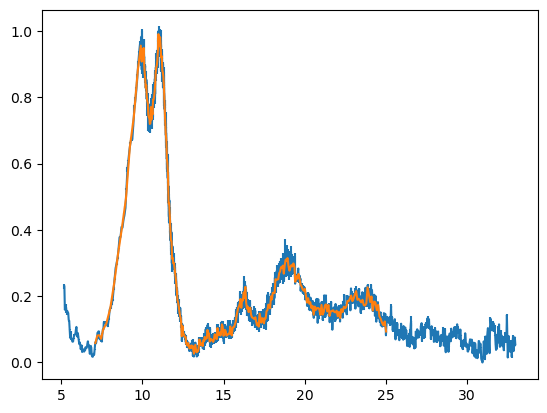

In [5]:
plt.figure()
plt.errorbar(irs['wave'], irs['em'], yerr=irs['em_unc'],
            label='Original data')
plt.errorbar(grid, irs_wav_interp.flatten(),
            label='Resampled data')
plt.show()

## ✅ Okay it looks alright. No abnormalies from interpolation. Move on. 

## Run Sequencer 
(Please refer to the mighty https://github.com/dalya/Sequencer repo for more details)
here we used EMD and L2 for our purpose. 

This step gives you 
- ``objects_list_shuffled''
- ``final_elongation''
- ``final_sequence''


In [6]:
estimator_list = ['EMD','L2']
scale_list = [[1, 2, 5, 10, 15, 20, 50],
             [1, 2, 5, 10, 15, 20, 50]]
r,c = np.shape(lib)
ind_shuffle = np.arange(r)
random.shuffle(ind_shuffle)
# objects_list_shuffled = lib+1
temp= lib+1
objects_list_shuffled = temp[ind_shuffle][:]
print(np.shape(grid), np.shape(objects_list_shuffled))
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list, scale_list)
output_path = "out/"
final_elongation, final_sequence = seq.execute(output_path)
print("resulting elongation for the Sequencer: ", final_elongation)


(309,) (35, 309)
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 0.05903792381286621 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 0.06854605674743652 seconds
calculating the distance matrices for estimator: EMD, scale: 5
finished calculating this distance matrix list, it took: 0.10077071189880371 seconds
calculating the distance matrices for estimator: EMD, scale: 10
finished calculating this distance matrix list, it took: 0.16413497924804688 seconds
calculating the distance matrices for estimator: EMD, scale: 15
finished calculating this distance matrix list, it took: 0.2298591136932373 seconds
calculating the distance matrices for estimator: EMD, scale: 20
finished calculating this distance matrix list, it took: 0.2933318614959717 seconds
calculating the distance matrices for estimator: EMD, scale: 50
finished calculating this dist

/Users/cicero/miniconda3/envs/sequencer_pytorch/lib/python3.9/site-packages/sequencer/sequencer_.py:1025: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


## Print the resulting elongations

In [7]:
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   np.round(elongation_list[i], 2)))

intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 11.98
metric=EMD, scale=2, elongation: 18.44
metric=EMD, scale=5, elongation: 13.44
metric=EMD, scale=10, elongation: 19.37
metric=EMD, scale=15, elongation: 21.16
metric=EMD, scale=20, elongation: 15.98
metric=EMD, scale=50, elongation: 12.92
metric=L2, scale=1, elongation: 17.61
metric=L2, scale=2, elongation: 17.85
metric=L2, scale=5, elongation: 20.61
metric=L2, scale=10, elongation: 19.53
metric=L2, scale=15, elongation: 16.96
metric=L2, scale=20, elongation: 15.98
metric=L2, scale=50, elongation: 14.51


## Read in the sequencer output for further analyses

Useful items from this step:
- ``dis_matrices''
- ``sparse_dis_matrix_weighted''
- ``final_products''

In [8]:
import pickle
import seaborn as sns

fname1 = output_path+'distance_matrices.pkl'
with open(fname1, 'rb') as f:
    dis_matrices = pickle.load(f)
fname2 = output_path+'weighted_distance_matrix.pkl'
with open(fname2, 'rb') as f:
    sparse_dis_matrix_weighted = pickle.load(f)
    
fname3 = output_path+'final_products.pkl'
with open(fname3, 'rb') as f:
    final_products = pickle.load(f)

## This returns the final MST weighted over all scales

In [9]:
final_mst = seq.return_final_MST()

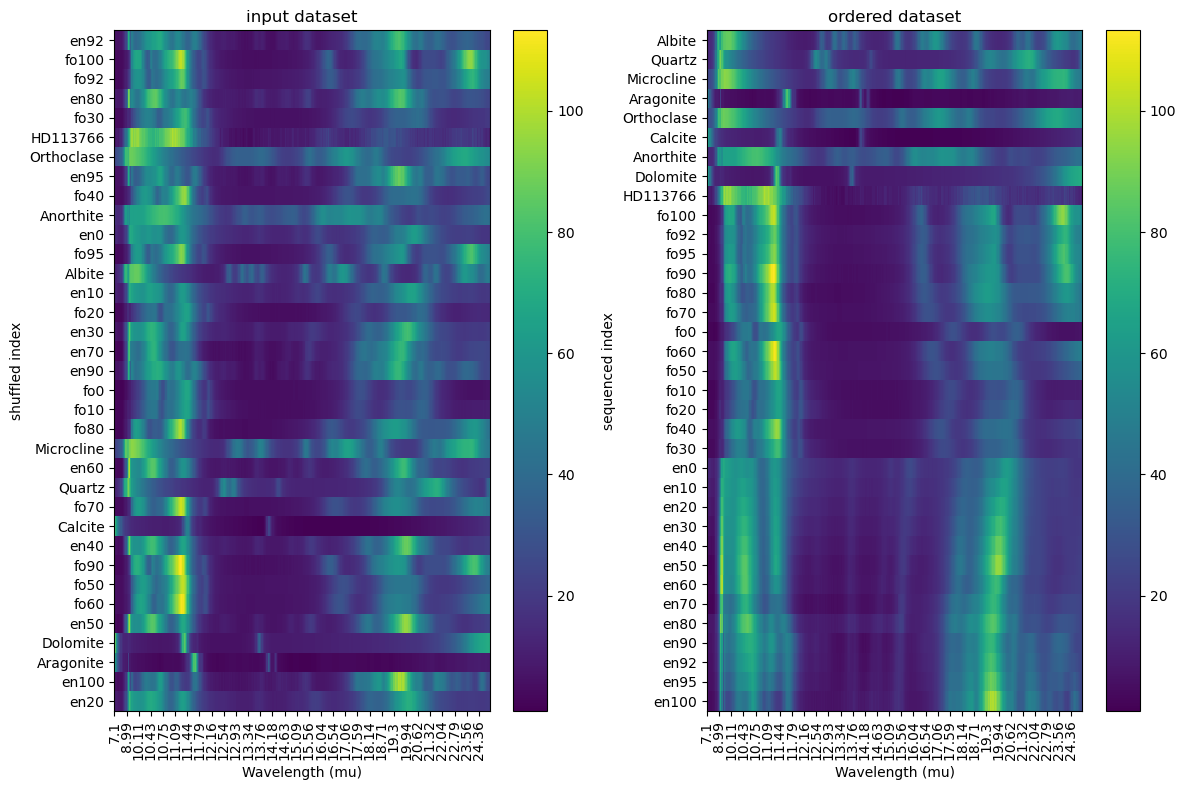

In [11]:
data = np.copy(objects_list_shuffled)
object_names = key['shortkey']
shuffled_names = np.array(object_names)[ind_shuffle]

# visualize the ordered dataset
plot_seq(objects_list_shuffled, 
             final_sequence, 
             key, 
             ind_shuffle, 
             grid,
             save_switch=True,
             fname = 'out/OneD_libSeq.pdf')